In [1]:
# Std imports
import time
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import h5py
import networkx as nx
import itertools

# Scipy imports
from scipy.interpolate import InterpolatedUnivariateSpline
from scipy.integrate import trapezoid
from scipy.integrate import cumulative_trapezoid # integral discrete func
from scipy.fft import fft, fftfreq, fftshift
from sklearn.metrics import r2_score
from scipy.signal import find_peaks
from sklearn.metrics import mean_squared_error

# Waveform imports
from lib.Tweezer_control_software.AOD.signal.waveform_gen import move_atom_wave_gen

#### Plot Configurations

In [2]:
def plot_configs(ax):
    # plt.rcParams['text.usetex'] = True

    # Set bourder line
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(1.5)

    # Tick parameters
    ax.tick_params(axis = 'both', which = 'major', length = 6, width = 1, direction = 'in', labelsize = 16)
    ax.tick_params(axis = 'both', which = 'minor', length = 4, width = 1, direction = 'in', labelsize = 16)
    ax.tick_params(labelbottom = True, labeltop = False, labelleft = True, labelright = False,
                     bottom = True, top = True, left = True, right = True)
    ax.yaxis.set_tick_params(right='on',which='both')
    return ax

filled_marker_style_blue = dict(marker='o', linestyle='None', markersize=2,
                           color='darkgrey',
                           markerfacecolor='lightsteelblue',
                           markerfacecoloralt='lightsteelblue',
                           markeredgecolor='tab:blue')

filled_marker_style_red = dict(marker='o', linestyle='None', markersize=2,
                           color='darkgrey',
                           markerfacecolor='lightsteelblue',
                           markerfacecoloralt='lightsteelblue',
                           markeredgecolor='tab:red')

# Plot the original data and the polynomial fit
filled_marker_style_blue_larger = dict(marker='o', linestyle='None', markersize=10,
                           color='darkgrey',
                           markerfacecolor='lightsteelblue',
                           markerfacecoloralt='lightsteelblue',
                           markeredgecolor='tab:blue')

filled_marker_style_red_larger = dict(marker='o', linestyle='None', markersize=10,
                           color='darkgrey',
                           markerfacecolor='lightsteelblue',
                           markerfacecoloralt='lightsteelblue',
                           markeredgecolor='tab:red')

#### Spectrum Plot

In [3]:
def plot_spectrum(t_data, signal_data, t_spacing, plot = True):
    """
    
    Returns:
        spectrum2D : array
            Columns are the periodograms of successive segments.
        freqs1-D : array
            The frequencies corresponding to the rows in spectrum.
        t : 1-D array
            The times corresponding to midpoints of segments (i.e., the columns in spectrum).
        im : AxesImage
            The image created by imshow containing the spectrogram.
    """
    # Plot config
    fig = plt.figure(figsize=(20, 3))
    ax = fig.add_subplot(131)
    ax1 = fig.add_subplot(132)
    ax2 = fig.add_subplot(133)
    
    scalMEGA = 1e6
    tickMEGA = ticker.FuncFormatter(lambda x, post: '{0:g}'.format(x/scalMEGA))

    scalmicro = 1e-6
    tickmicro = ticker.FuncFormatter(lambda x, post: '{0:g}'.format(x/scalmicro))

    # Sample rate
    fs = 1/t_spacing
    
    # FFT
    N = len(t_data)
    yf = fft(signal_data)
    xf = fftfreq(N, t_spacing)[:N//2]

    if plot:
        Pxx, freqs, bins, scectrogram = plt.specgram(signal_data, Fs=fs, NFFT=1024, scale = 'linear', cmap='bone')
        plt.close()
    else: 
        Pxx, freqs, bins, scectrogram = plt.specgram(signal_data, Fs=fs, NFFT=1024, scale = 'linear', cmap='bone');
    
    if plot:
        # Time domain
        plot_configs(ax)
        ax.plot(t_data, signal_data)
        ax.set_xlabel("Time ($\mu$s)")
        ax.set_ylabel("Amp")
        ax.xaxis.set_major_formatter(tickmicro)
        
        # Frequency domain
        plot_configs(ax1)
        ax1.plot(xf, 2/N * np.abs(yf[0:N//2]))
        ax1.set_xlabel("MHz")
        ax1.set_ylabel("Intensity")
        ax1.xaxis.set_major_formatter(tickMEGA)
        ax1.set_xlim(50e6, 95e6)

        # Spectrogram
        # Pxx is the intensity of each frequency point
        ax2.set_xlabel(r"Time ($\mu$s)")
        ax2.set_ylabel(r'Freq (MHz)')
        ax2.xaxis.set_major_formatter(tickmicro)
        ax2.yaxis.set_major_formatter(tickMEGA)
        ax2.set_ylim(50e6, 115e6)

        cbar = fig.colorbar(scectrogram, ax=ax2)

        plt.tight_layout()
        plt.show()
        plt.close()

    return Pxx, freqs, bins

#### Unit conversion

In [4]:
scalMEGA = 1e6
tickMEGA = ticker.FuncFormatter(lambda x, post: '{0:g}'.format(x/scalMEGA))

scalmicro = 1e-6
tickmicro = ticker.FuncFormatter(lambda x, post: '{0:g}'.format(x/scalmicro))

#### Generate Signal Workspace
Generate the moving sigals through `move_atom_wave_gen()`, and visualize the results with DAC output, periodogram, spectrogram.

In [5]:
freq_list = [[70, 75], [90, 85]]
Amp_mt = 1
phase = np.zeros((2, 1))
ave_velocity = 1e-1
trap_spacing = 5e-6
signal_data, freq_data, t_data, t_spacing = move_atom_wave_gen(freq_list, Amp_mt, phase, ave_velocity, trap_spacing, awg_resolution = 625e06)

# Plot spectrogram
xPxx, xfreqs, xbins = plot_spectrum(t_data, signal_data[0], t_spacing)
yPxx, yfreqs, ybins = plot_spectrum(t_data, signal_data[1], t_spacing)


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

Plot the frequency

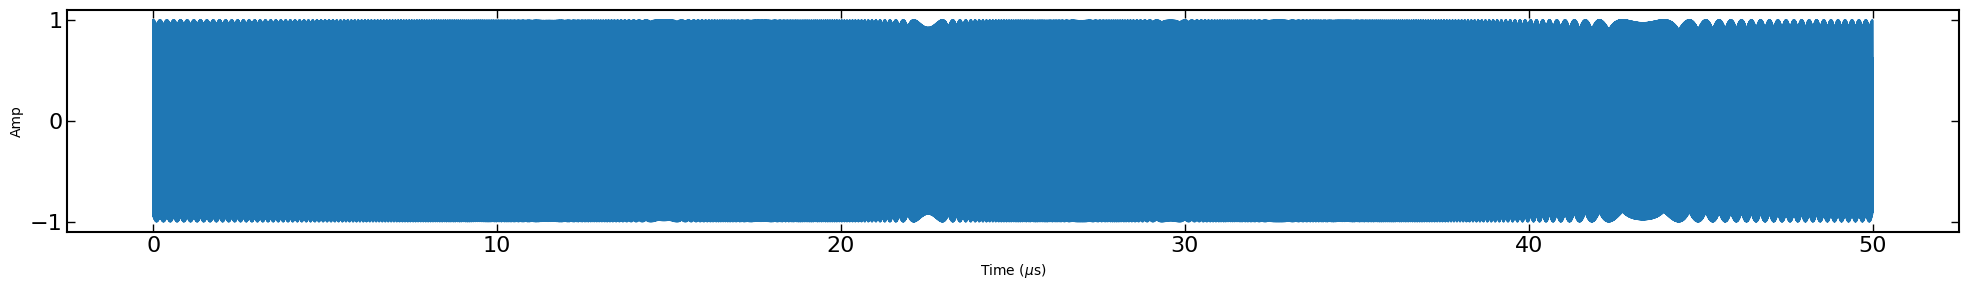

31250


In [6]:
# Time domain
fig = plt.figure(figsize=(20, 3))
ax = fig.add_subplot(111)
plot_configs(ax)
ax.plot(t_data, signal_data[0])
ax.set_xlabel("Time ($\mu$s)")
ax.set_ylabel("Amp")
ax.xaxis.set_major_formatter(tickmicro)
plt.tight_layout()
plt.show()

print(len(signal_data[0]))

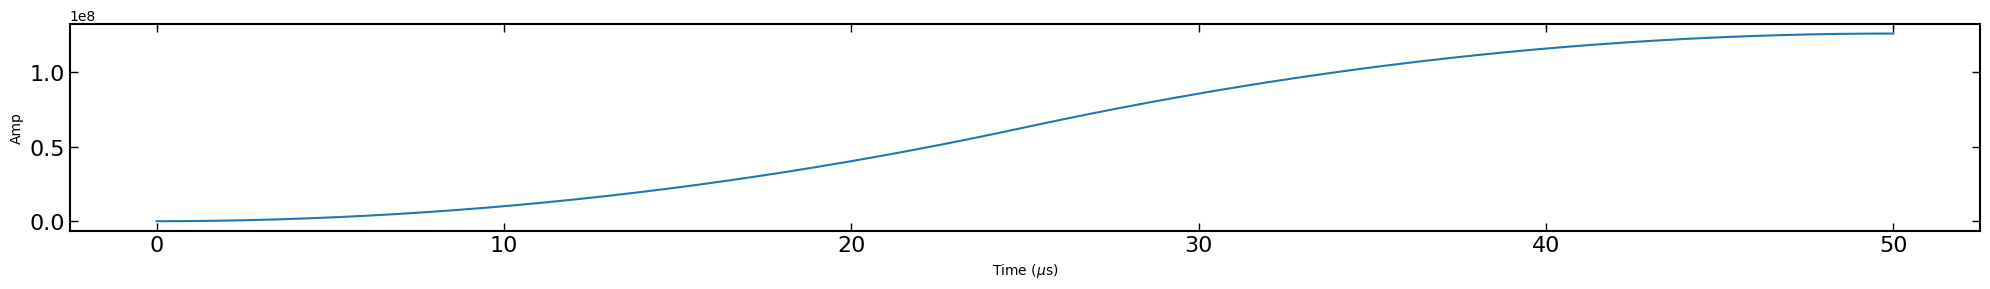

Freq start: 0.0, Freq end: 19999999.95904


In [7]:
# Time domain
fig = plt.figure(figsize=(20, 3))
ax = fig.add_subplot(111)
plot_configs(ax)
ax.plot(t_data, freq_data[0])
ax.set_xlabel("Time ($\mu$s)")
ax.set_ylabel("Amp")
ax.xaxis.set_major_formatter(tickmicro)
plt.tight_layout()
plt.show()

print(f"Freq start: {freq_data[0][0]}, Freq end: {freq_data[0][-1]/(2 * np.pi)}")

# Data Analysis

#### Ground Truth Analytical

In [8]:
def freq_function_ground_truth_analytical(freq_list, Amp_mt, phase, ave_velocity, trap_spacing, awg_resolution = 625e06):
    """
    We have the analytical ground truth
    """
    pass

#### Fit the ground truth (Although we have the analytical function already)

In [9]:
def freq_function_ground_truth(freq_list, Amp_mt, phase, ave_velocity, trap_spacing, awg_resolution = 625e06):
    """
    Obtaining the ground truth funciton of thefrequency ramp function
    """
    # Obtaining ground truth data
    signal_data, freq_data_set, t_data, t_spacing = move_atom_wave_gen(freq_list, Amp_mt, phase, ave_velocity, trap_spacing, awg_resolution = 625e06)

    ground_truth_set = []
    for freq_data in freq_data_set:
        x = t_data
        y = freq_data/(2 * np.pi)    
        # Fit the ground truth data
        # Use np.polyfit to fit a polynomial of degree n to the data.
        # It returns co-efficients in decreasing order i.e., [An, An-1, ..., A0]
        n = 10 # Degree of polynomial
        coefficients = np.polyfit(x, y, n)

        # Now, we create a polynomial function with these coefficients
        polynomial = np.poly1d(coefficients)

        # Now we can use this 'polynomial' just like a function to calculate y-values
        y_fit_ground_truth = polynomial(x)
        ground_truth_set.append(y_fit_ground_truth)

    return t_data, freq_data_set, ground_truth_set


The R-squared value is  0.999992211660851


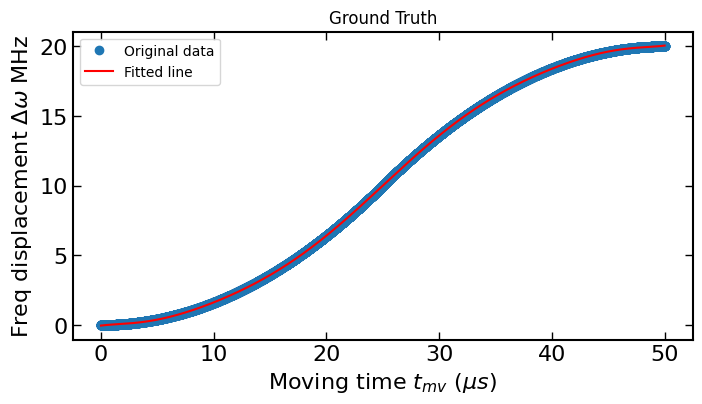

In [10]:

t_data, freq_data_set, ground_truth_set = freq_function_ground_truth(freq_list, Amp_mt, phase, ave_velocity, trap_spacing, awg_resolution = 625e06)

# calculate r-squared
r2 = r2_score(freq_data_set[0]/(2 * np.pi) , ground_truth_set[0])

print('The R-squared value is ', r2)

# Plot the original data and the polynomial fit
fig, ax = plt.subplots(figsize=(8,4))
plot_configs(ax)

ax.plot(t_data, freq_data_set[0]/(2 * np.pi) , 'o', label='Original data')
ax.plot(t_data, ground_truth_set[0], 'r', label='Fitted line')
ax.xaxis.set_major_formatter(tickmicro)
ax.yaxis.set_major_formatter(tickMEGA)

ax.set_title("Ground Truth")
ax.set_xlabel("Moving time $t_{mv}$ $(\mu s)$", fontsize = 16)
ax.set_ylabel("Freq displacement $\Delta\omega$ MHz", fontsize=16)
plt.legend()
plt.show()

# Partition

In [11]:
def partition(freq_data, signal_data, t_data, partition_rate = 0.01, plot = True):
	"""
	Partition the FFT based on rate of change in frequency domain.
	We assume that in each partition section, the frequency remain the same.
	Where FFT is the fourier transform of the rearranging waveform.

	Parameters
	----------
	freq_data : array 
		The frequency of ONE Channel
		Call this function twice to generate both channels

	# TODO: 
		# Return the partition sections on the time axis
		# in the fomat [section0, section1, ...]
	"""
	# generate required data
	
	# Sample rate
	fs = 1/t_spacing
	
	if plot:
		Pxx, freqs, bins, scectrogram = plt.specgram(signal_data, Fs=fs, NFFT=1024, cmap='bone')
	else:
		Pxx, freqs, bins, scectrogram = plt.specgram(signal_data, Fs=fs, NFFT=1024, cmap='bone');

	t_x_freq = abs(freq_data[0] - freq_data[-1])/(2 * np.pi)
	t_x_freq_limit = partition_rate * t_x_freq

	# max_freqs = []
	partition_bins = []
	# for j in range(Pxx.shape[1]):
	# 	#print(bins[j],freqs[np.argmax(Pxx[:,j])])
	# 	max_freqs.append(freqs[np.argmax(Pxx[:,j])])

	start_max_freq = freq_data[0]
	start_index = 0
	for j in range(len(freq_data)):
		if j == (len(freq_data)-1):
			partition_bins.append([start_index,j])
		
		if abs(freq_data[j]-start_max_freq) < t_x_freq_limit:
			continue
		else:
			partition_bins.append([start_index,j-1])
			start_max_freq = freq_data[j]
			start_index = j

	# print(partition_bins)
	# print(len(partition_bins))
	return partition_bins
	

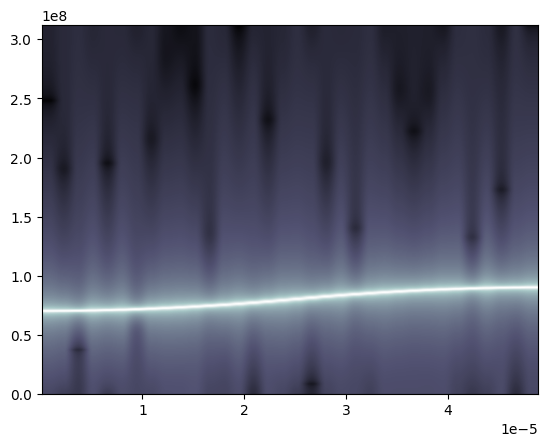

In [12]:
partition_bins = partition(freq_data[0], signal_data[0],t_data, 0.05, plot = False)

### Sampling

In [13]:
def sampling(initial_freq, signal_data, freq_data, partition):
    """
    Sampling the original waveform based on the FFT partition.
    For each partition section, we sample at most 4 points 
    [start, end]: remain the phase continoulity
    [consecuitive max (crest) and min (through]: retrieve the amplitude and frequency

    Note
    ----
    Where FFT is the fourier transform of the rearranging waveform.

    Parameters
    ----------
    partition : array
        The partition in time based on the FFT.
    signal_data : array
        The rearramging waveform.
    """
    # For each section in patition
    # We can access the data that we want 
    sampled_data = []
    for section in partition:
        # We want to sample the waveform based on the given partition
        section_data = signal_data[section[0]: section[1]]
        initial_data = section_data[0]
        final_data = section_data[-1]
        peaks, _ = find_peaks(section_data)
        mins, _ = find_peaks(-section_data)
        amplitude = (section_data[peaks[0]] - section_data[mins[0]]) / 2
        frequency = initial_freq*1e6 + sum(freq_data[section[0]: section[1]])/len(freq_data[section[0]: section[1]])/(2*np.pi)
        # print(frequency)
        # frequency = 1/(abs(peaks[0] - mins[0])*2*t_spacing) # Do we need a 2pi factor?
        duration = len(section_data)
        sampled_data.append([initial_data, 
                        final_data, 
                        amplitude, 
                        frequency,
                        duration
                        ])
        
    return sampled_data

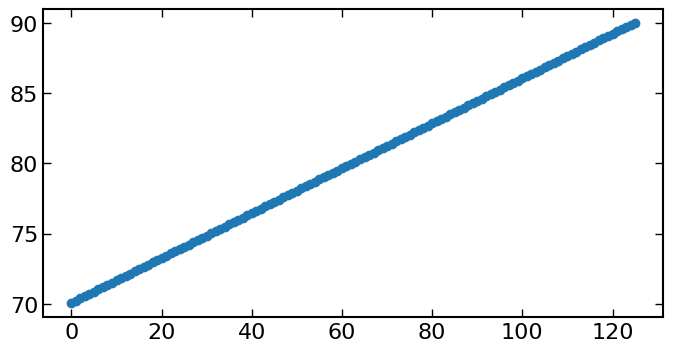

In [14]:
sampled_data = sampling(freq_list[0][0], signal_data[0], freq_data[0], partition_bins)

freq_array = []
for sample in sampled_data:
    # print(sample[3])
    freq_array.append(sample[3])

fig, ax = plt.subplots(figsize=(8,4))
plot_configs(ax)

x_data = list(range(len(freq_array)))
ax.plot(x_data, freq_array, 'o')
ax.yaxis.set_major_formatter(tickMEGA)


### Compression rate

In [15]:
def compression_rate(sampled_data, signal_data):
    num_sampled_data = len(list(itertools.chain(*sampled_data)))
    num_signal_data = len(signal_data[0])
    compression_ratio = num_sampled_data/num_signal_data
    return compression_ratio

print(f'Compression rate: {compression_rate(sampled_data, signal_data)}')

Compression rate: 0.02016


### Decompression

In [16]:
# decoder/decompression
import math

def decompress(sampled_data, t_data):
	"""
	The conventional decompressor that can reconstruct the waveform based on sampled_data.

	Parameters
	"""
	def custom_sin_function(t, A=1, f=1, φ=0):
		return A * math.sin(2 * math.pi * f * t + φ)
	def calculate_phase(t, y, A, f):
		inner_value = y / A
		# Check value is in valid range for arcsin
		if -1 <= inner_value <= 1:
			# math.asin returns in range -pi/2 to pi/2
			phase = math.asin(inner_value) - (2 * math.pi * f * t)
			# Shift phase to range 0 to 2pi
			phase = (phase + 2 * math.pi) % (2 * math.pi)
			return phase
		else:
			print("Error: Invalid inner value for arcsine")
			return None
			
	start_index = 0
	y=[]
	for data in sampled_data:
		phase = calculate_phase(t_data[start_index], data[0], 1, data[3])
		phase2 = calculate_phase(t_data[start_index+data[4]], data[1], 1, data[3])
		phase = (phase+phase2)/2
		for t in range(data[4]+1):
			y.append(custom_sin_function(t_data[start_index+t],1,data[3],phase))
		start_index = start_index + data[4] + 1
	
	return y

decompressed_data = decompress(sampled_data, t_data)

xPxx_de, xfreqs_de, xbins_de = plot_spectrum(t_data,decompressed_data,t_spacing)

<Figure size 640x480 with 0 Axes>

#### Decompress: Approximate Computing

In [17]:
# approximate decoder/decompression 
import math
import random
# no errror: 8346.31ps
# error rate: 1/2^9 7975.38ps
# error rate: 1/2^8 7996.20ps
# error rate: 1/2^7 7983.40ps
# error rate: 1/2^6 7813.55 ps

def decompress_approx(sampled_data, t_data, error_rate):
	def custom_sin_function(t, A=1, f=1, φ=0):
		return A * math.sin(2 * math.pi * f * t + φ)
	
	def calculate_phase(t, y, A, f):
		inner_value = y / A
		# Check value is in valid range for arcsin
		if -1 <= inner_value <= 1:
			# math.asin returns in range -pi/2 to pi/2
			phase = math.asin(inner_value) - (2 * math.pi * f * t)
			# Shift phase to range 0 to 2pi
			phase = (phase + 2 * math.pi) % (2 * math.pi)
			return phase
		else:
			print("Error: Invalid inner value for arcsine")
			return None
			
	start_index = 0
	y=[]
	for data in sampled_data:
		phase = calculate_phase(t_data[start_index], data[0], 1, data[3])
		phase2 = calculate_phase(t_data[start_index+data[4]], data[1], 1, data[3])
		phase = (phase+phase2)/2
		for t in range(data[4]+1):
			if random.choice([True, False]):
				y.append(custom_sin_function(t_data[start_index+t],1,data[3],phase)*(1+error_rate))
			else:
				y.append(custom_sin_function(t_data[start_index+t],1,data[3],phase)*(1-error_rate))

		start_index = start_index + data[4] + 1
	
	return y
decompressed_data_approx = decompress_approx(sampled_data, t_data, 1/pow(2,6))

xPxx_de_approx, xfreqs_de_approx, xbins_de_approx = plot_spectrum(t_data, decompressed_data_approx, t_spacing)

<Figure size 640x480 with 0 Axes>

In [18]:
print(decompressed_data)
print(decompressed_data_approx)

[0.9385960929867139, 0.9386879061327785, 0.49214757897918276, -0.18855889126273814, -0.7795481502494677, -0.9996247165959325, -0.7440751203458913, -0.1344910666658588, 0.5390844718982456, 0.9561610719832511, 0.9182917169099835, 0.4434948247252044, -0.24231900022787928, -0.8128363001059452, -0.996602248381724, -0.7061801387160999, -0.07975418290390626, 0.5846191899097201, 0.9708279902986762, 0.8951122465052336, 0.3934978671236167, -0.29534465640318835, -0.8436607971422652, -0.9905591449676816, -0.6661447720050047, -0.024775569512504092, 0.6283819659991181, 0.9825523934780561, 0.8692197503532647, 0.3423082436310781, -0.3474751425478596, -0.8719282143559118, -0.981513722598745, -0.6240903647491275, 0.03027813698398989, 0.6702401580997515, 0.9912987456343318, 0.8406927068895982, 0.2900811065953105, -0.3985524546219844, -0.8975528750834194, -0.9694933973491298, -0.5801443810627342, 0.0852400724589843, 0.7100668968124503, 0.9970405371552329, 0.8096175796876125, 0.23697475299866524, -0.448421

### Comparison

Compare the ground truth an the decompressed frequency ramping.

0.9933057473620718


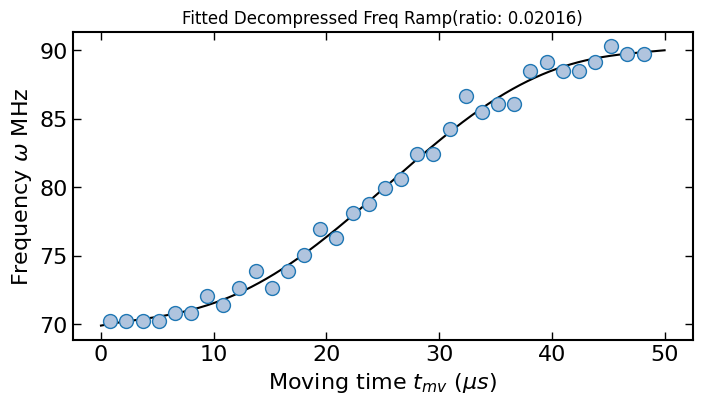

0.9933057473620718


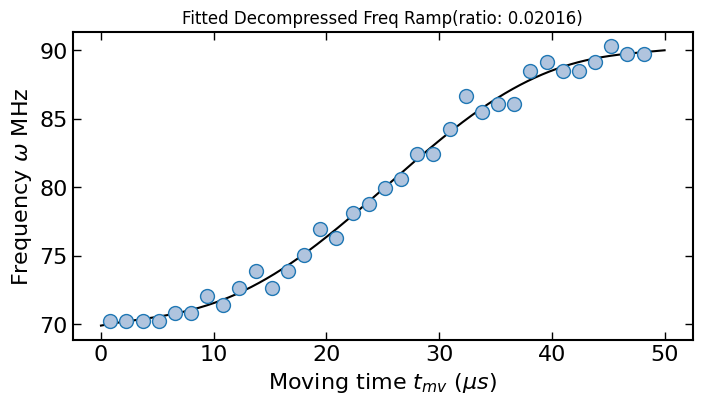

In [19]:
# fit 
# fit to get the analytical solution of the curve for easier comparison
def fit(Pxx, freqs, bins, t_data, plot = True):
	max_freqs = []
	for j in range(Pxx.shape[1]):
		max_freqs.append(freqs[np.argmax(Pxx[:,j])])

	# fit the graph
	max_freqs_fit = []
	
	# slow changing phase in the begining
	# Fit the graph
	coefficients = np.polyfit(bins, max_freqs, 5)
	polynomial = np.poly1d(coefficients)
	
	
	# Plot the original data and the polynomial fit
	if plot:
		fig, ax = plt.subplots(figsize=(8,4))
		plot_configs(ax)
		ax.plot(t_data, polynomial(t_data), "k")
		ax.plot(bins, max_freqs, **filled_marker_style_blue_larger)
		r2 = r2_score(max_freqs, polynomial(bins))
		print(r2)
		ax.xaxis.set_major_formatter(tickmicro)
		ax.yaxis.set_major_formatter(tickMEGA)
		ax.set_title(f"Fitted Decompressed Freq Ramp(ratio: {compression_rate(sampled_data, signal_data)})")
		ax.set_xlabel("Moving time $t_{mv}$ $(\mu s)$", fontsize = 16)
		ax.set_ylabel("Frequency $\omega$ MHz", fontsize=16)
		plt.show()
		plt.close()

	
	fit_decompressed_data = polynomial(t_data)
	return fit_decompressed_data

# Fit the conventional decoder
fit_decompressed_data = fit(xPxx_de, xfreqs_de, xbins_de, t_data)

# Fit the approximated decoder
fit_decompressed_data_approx = fit(xPxx_de_approx, xfreqs_de_approx, xbins_de_approx, t_data)

The MSE of conventional decompression is  0.012582706700058816
The MSE of approximate decompression is  0.012582706700058816


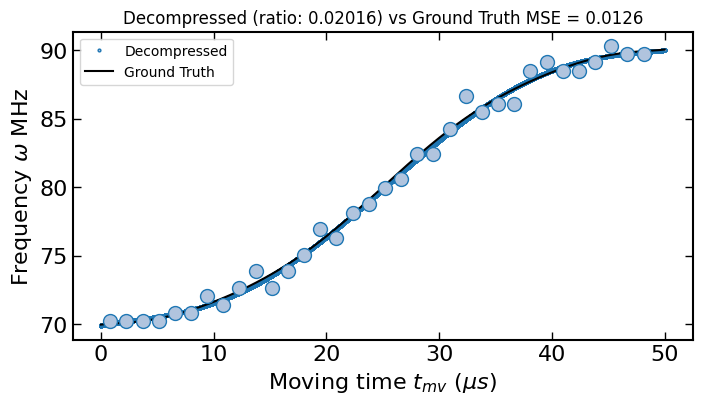

In [20]:
# calculate r-squared
mse = mean_squared_error(fit_decompressed_data*1e-6 , (freq_list[0][0]*1e6+ np.array(ground_truth_set[0]))*1e-6)
mse_approx = mean_squared_error(fit_decompressed_data_approx*1e-6 , (freq_list[0][0]*1e6+ np.array(ground_truth_set[0]))*1e-6)
print('The MSE of conventional decompression is ', mse)
print('The MSE of approximate decompression is ', mse_approx)

# Plot the original data and the polynomial fit
fig, ax = plt.subplots(figsize=(8,4))
plot_configs(ax)

ax.plot(t_data, fit_decompressed_data , label='Decompressed', **filled_marker_style_blue)
# ax.plot(t_data, fit_decompressed_data , label='Decompressed Approximate', **filled_marker_style_red)
ax.plot(t_data, freq_list[0][0]*1e6+ np.array(ground_truth_set[0]), 'k', label='Ground Truth')
ax.xaxis.set_major_formatter(tickmicro)
ax.yaxis.set_major_formatter(tickMEGA)

ax.set_title(f"Decompressed (ratio: {compression_rate(sampled_data, signal_data)}) vs Ground Truth MSE = {round(mse, 4)}")
ax.set_xlabel("Moving time $t_{mv}$ $(\mu s)$", fontsize = 16)
ax.set_ylabel("Frequency $\omega$ MHz", fontsize=16)

# Import and plot the decompressed data
max_freqs = []
for j in range(xPxx_de.shape[1]):
    max_freqs.append(xfreqs_de[np.argmax(xPxx_de[:,j])])
ax.plot(xbins_de, max_freqs, **filled_marker_style_blue_larger)

plt.legend()
plt.show()

Try to see what is the MSE comparison 

In [21]:
# Evaluate the decompressed waveform
# Import and plot the decompressed data

def get_MSE(xPxx_de, xbins_de, xfreqs_de):
    max_freqs = []
    for j in range(xPxx_de.shape[1]):
        max_freqs.append(xfreqs_de[np.argmax(xPxx_de[:,j])])

    coefficients = np.polyfit(xbins_de, max_freqs, 5)
    polynomial = np.poly1d(coefficients)
    return mean_squared_error(np.array(max_freqs)*1e-6, polynomial(xbins_de)*1e-6)

print(get_MSE(xPxx_de, xbins_de, xfreqs_de))

0.35087555539060844


#### Some Checks
Here we assume that the $R^2$ score is proportional to rearraning success rate. So we are wondering what is impact of compression rate on $R^2$.

In [22]:
mse_list = []
mse_approx_list = []
partition_rate_scan = np.linspace(0.01, 0.5, 10)
compression_rate_list = []
plt.ioff()
for partition_rate in partition_rate_scan:
    # Partition the waveform
    partition_bins = partition(freq_data[0], signal_data[0],t_data, partition_rate, plot = False)
    
    # Sample the waveform based on partition
    sampled_data = sampling(freq_list[0][0], signal_data[0], freq_data[0], partition_bins)

    # Decompress
    decompressed_data = decompress(sampled_data, t_data)
    decompressed_data_approx = decompress_approx(sampled_data, t_data, 1/pow(2,6))
    xPxx_de_approx, xfreqs_de_approx, xbins_de_approx = plot_spectrum(t_data, decompressed_data_approx, t_spacing, plot = False)
    xPxx_de, xfreqs_de, xbins_de = plot_spectrum(t_data,decompressed_data,t_spacing, plot = False)
    
    # Evaluate the decompressed waveform
    # Import and plot the decompressed data
    max_freqs = []
    for j in range(xPxx_de.shape[1]):
        max_freqs.append(xfreqs_de[np.argmax(xPxx_de[:,j])])
    ax.plot(xbins_de, max_freqs, **filled_marker_style_blue_larger)
    
    fit_decompressed_data = fit(xPxx_de, xfreqs_de, xbins_de, t_data, plot = False)
    fit_decompressed_data_approx = fit(xPxx_de_approx, xfreqs_de_approx, xbins_de_approx, t_data, plot = False)
    # mse = mean_squared_error(fit_decompressed_data*1e-6 , (freq_list[0][0]*1e6+ np.array(ground_truth_set[0]))*1e-6)
    # mse_approx = mean_squared_error(fit_decompressed_data_approx*1e-6 , (freq_list[0][0]*1e6+ np.array(ground_truth_set[0]))*1e-6)
    
    xPxx_de, xbins_de, xfreqs_de
    mse = get_MSE(xPxx_de,  xbins_de, xfreqs_de)
    mse_approx = get_MSE(xPxx_de_approx, xbins_de_approx, xfreqs_de_approx)
    
    # Collect data
    mse_list.append(mse)
    mse_approx_list.append(mse_approx)
    compression_rate_list.append(compression_rate(sampled_data, signal_data))
    plt.close('all')
    
    print(f'Partition rate: {round(partition_rate, 3)}, Compression rate: {round(compression_rate(sampled_data, signal_data), 3)}, MSE of decompressed: {round(mse, 5)}, approximate decompressed: {round(mse_approx, 5)}')

Partition rate: 0.01, Compression rate: 0.099, MSE of decompressed: 2.40654, approximate decompressed: 2.40654
Partition rate: 0.064, Compression rate: 0.016, MSE of decompressed: 0.35821, approximate decompressed: 0.35821
Partition rate: 0.119, Compression rate: 0.008, MSE of decompressed: 0.07856, approximate decompressed: 0.07856
Partition rate: 0.173, Compression rate: 0.006, MSE of decompressed: 0.19161, approximate decompressed: 0.19161
Partition rate: 0.228, Compression rate: 0.004, MSE of decompressed: 0.05066, approximate decompressed: 0.05066
Partition rate: 0.282, Compression rate: 0.004, MSE of decompressed: 0.08803, approximate decompressed: 0.08803
Partition rate: 0.337, Compression rate: 0.003, MSE of decompressed: 0.10331, approximate decompressed: 0.10331
Partition rate: 0.391, Compression rate: 0.003, MSE of decompressed: 0.1052, approximate decompressed: 0.1052
Partition rate: 0.446, Compression rate: 0.002, MSE of decompressed: 0.17049, approximate decompressed: 0.1

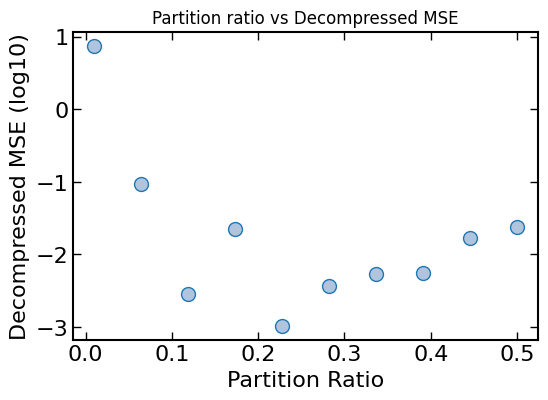

In [23]:
fig, ax = plt.subplots(figsize=(6,4))
plot_configs(ax)

ax.plot(partition_rate_scan, np.log(np.array(mse_list)) , label='Decompressed log10 MSE', **filled_marker_style_blue_larger)
# ax.plot(partition_rate_scan, r2_approx_list  , label='Decompressed Approx R2', **filled_marker_style_red_larger)
# ax.set_ylim(0.98, 1)

ax.set_title(f"Partition ratio vs Decompressed MSE")
ax.set_xlabel("Partition Ratio", fontsize = 16)
ax.set_ylabel("Decompressed MSE (log10)", fontsize=16)
# plt.legend()
plt.show()

Plot partition ration against compression rate.

In [24]:
partition_rate_scan = np.concatenate((np.linspace(0.005, 0.01, 3), np.linspace(0.01, 0.1, 10)))
compression_rate_list = []
plt.ioff()
for partition_rate in partition_rate_scan:
    # Partition the waveform
    partition_bins = partition(freq_data[0], signal_data[0],t_data, partition_rate, plot = False)
    
    # Sample the waveform based on partition
    sampled_data = sampling(freq_list[0][0], signal_data[0], freq_data[0], partition_bins)

    # Collect data
    compression_rate_list.append(compression_rate(sampled_data, signal_data))
    plt.close('all')
    
    print(f'Partition rate: {round(partition_rate, 3)}, Compression rate: {round(compression_rate(sampled_data, signal_data), 3)}')

Partition rate: 0.005, Compression rate: 0.196
Partition rate: 0.008, Compression rate: 0.132
Partition rate: 0.01, Compression rate: 0.099
Partition rate: 0.01, Compression rate: 0.099
Partition rate: 0.02, Compression rate: 0.05
Partition rate: 0.03, Compression rate: 0.033
Partition rate: 0.04, Compression rate: 0.025
Partition rate: 0.05, Compression rate: 0.02
Partition rate: 0.06, Compression rate: 0.017
Partition rate: 0.07, Compression rate: 0.014
Partition rate: 0.08, Compression rate: 0.013
Partition rate: 0.09, Compression rate: 0.011
Partition rate: 0.1, Compression rate: 0.01


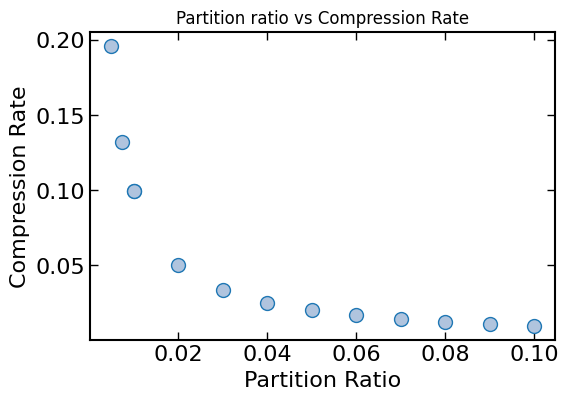

In [25]:
fig, ax = plt.subplots(figsize=(6,4))
plot_configs(ax)

ax.plot(partition_rate_scan, compression_rate_list, **filled_marker_style_blue_larger)
# ax.plot(partition_rate_scan, r2_approx_list  , label='Decompressed Approx R2', **filled_marker_style_red_larger)
# ax.set_ylim(0.98, 1)

ax.set_title(f"Partition ratio vs Compression Rate")
ax.set_xlabel("Partition Ratio", fontsize = 16)
ax.set_ylabel("Compression Rate", fontsize=16)
# plt.legend()
plt.show()